In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import pickle
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [23]:
dataset = pd.read_csv('../inputFile/modelInput/jlco0000st.csv')
y_train_dataset = dataset['Arousal'][3:]
dataset = dataset.drop(columns=['Time','FileName','Valence','Arousal'])

test_dataset = pd.read_csv('../inputFile/modelInput/sentences/allFileCombineSentenceP.csv')
y_test_dataset = test_dataset['Arousal'][3:]
test_dataset = test_dataset.drop(columns=['Time','Valence','Arousal'])

print(test_dataset.shape)
print(dataset.shape)


(1127890, 7)
(6708, 7)


In [24]:
# prepare data for lstms
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
values = dataset.values
test_values = test_dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
test_scaled = scaler.fit_transform(test_values)
# specify the number of lag hours
n_steps = 3
n_features = 7
# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps, 1)
test_reframed = series_to_supervised(test_scaled, n_steps, 1)
print(reframed.shape)
print(test_reframed.shape)
reframed


(6705, 28)
(1127887, 28)


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var1(t-2),var2(t-2),var3(t-2),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
3,0.066472,0.883593,0.143335,0.325372,0.671362,0.497958,0.553561,0.620374,0.559736,0.314630,...,0.549553,0.458428,0.255835,0.667523,0.955553,0.608385,0.696105,0.333164,0.211320,0.202974
4,0.620374,0.559736,0.314630,0.639718,0.793832,0.475425,0.552749,0.638235,0.884404,0.565454,...,0.333164,0.211320,0.202974,0.761568,0.863149,0.743923,0.727586,0.130966,0.284412,0.164695
5,0.638235,0.884404,0.565454,0.710028,0.549553,0.458428,0.255835,0.667523,0.955553,0.608385,...,0.130966,0.284412,0.164695,0.654475,0.759368,0.440599,0.692283,0.540758,0.409254,0.632774
6,0.667523,0.955553,0.608385,0.696105,0.333164,0.211320,0.202974,0.761568,0.863149,0.743923,...,0.540758,0.409254,0.632774,0.588683,0.750880,0.531398,0.545338,0.522091,0.536434,0.485780
7,0.761568,0.863149,0.743923,0.727586,0.130966,0.284412,0.164695,0.654475,0.759368,0.440599,...,0.522091,0.536434,0.485780,0.647049,0.616914,0.467859,0.590344,0.441643,0.702953,0.841408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6703,0.552912,0.657845,0.441001,0.456322,0.518398,0.753933,0.489218,0.475993,0.628936,0.082103,...,0.609719,0.367708,0.648170,0.446452,0.496727,0.227277,0.634626,0.784280,0.510368,0.568729
6704,0.475993,0.628936,0.082103,0.444981,0.794203,0.643323,0.654640,0.479762,0.553038,0.353995,...,0.784280,0.510368,0.568729,0.418395,0.443661,0.420567,0.215784,0.611283,0.758372,0.271837
6705,0.479762,0.553038,0.353995,0.698022,0.609719,0.367708,0.648170,0.446452,0.496727,0.227277,...,0.611283,0.758372,0.271837,0.450588,0.436206,0.418978,0.355374,0.260238,0.675750,0.585846
6706,0.446452,0.496727,0.227277,0.634626,0.784280,0.510368,0.568729,0.418395,0.443661,0.420567,...,0.260238,0.675750,0.585846,0.381439,0.528812,0.185911,0.570945,0.740476,0.514262,0.708086


In [25]:
# split into train and test sets
values = reframed.values
test_values = test_reframed.values
train = values
test = test_values

In [26]:
# split into input and outputs
n_obs = n_steps * n_features
train_X, train_y = train[:, :n_obs], y_train_dataset
test_X, test_y = test[:, :n_obs], y_test_dataset
print(train_X.shape, len(train_X), train_y.shape)

(6705, 21) 6705 (6705,)


In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6705, 3, 7) (6705,) (1127887, 3, 7) (1127887,)


Epoch 1/50
75/75 - 2s - loss: 0.3775 - val_loss: 0.2916
Epoch 2/50
75/75 - 0s - loss: 0.3583 - val_loss: 0.2835
Epoch 3/50
75/75 - 0s - loss: 0.3520 - val_loss: 0.2770
Epoch 4/50
75/75 - 0s - loss: 0.3468 - val_loss: 0.2720
Epoch 5/50
75/75 - 0s - loss: 0.3421 - val_loss: 0.2689
Epoch 6/50
75/75 - 0s - loss: 0.3388 - val_loss: 0.2669
Epoch 7/50
75/75 - 0s - loss: 0.3352 - val_loss: 0.2661
Epoch 8/50
75/75 - 0s - loss: 0.3319 - val_loss: 0.2648
Epoch 9/50
75/75 - 0s - loss: 0.3290 - val_loss: 0.2635
Epoch 10/50
75/75 - 0s - loss: 0.3262 - val_loss: 0.2621
Epoch 11/50
75/75 - 0s - loss: 0.3232 - val_loss: 0.2601
Epoch 12/50
75/75 - 0s - loss: 0.3195 - val_loss: 0.2578
Epoch 13/50
75/75 - 0s - loss: 0.3160 - val_loss: 0.2556
Epoch 14/50
75/75 - 0s - loss: 0.3126 - val_loss: 0.2541
Epoch 15/50
75/75 - 0s - loss: 0.3099 - val_loss: 0.2534
Epoch 16/50
75/75 - 0s - loss: 0.3080 - val_loss: 0.2518
Epoch 17/50
75/75 - 0s - loss: 0.3054 - val_loss: 0.2515
Epoch 18/50
75/75 - 0s - loss: 0.3045 - 

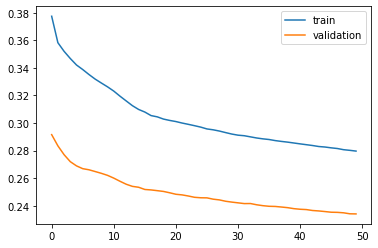

In [28]:
# design network
model = keras.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split = 0.2, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [29]:
print(test_X.shape)

(1127887, 3, 7)


In [39]:
# make a prediction
yhat = model.predict(test_X[:1000])
test_X = test_X.reshape((test_X.shape[0], n_steps*n_features))
# invert scaling for forecast
inv_yhat = yhat
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
inv_y = y_test_dataset[:1000]
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print(inv_yhat.shape, inv_y.shape)

ValueError: in user code:

    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Python39\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:215 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 21)


In [31]:
from sklearn.metrics import r2_score
r2_score(inv_y, inv_yhat)

-0.5376197877413182

In [32]:
pred_test_list = [i for i in inv_yhat]
submission = pd.DataFrame({'Arousal' : inv_y, 'Prediction' : pred_test_list})


1127887 (1127887,)


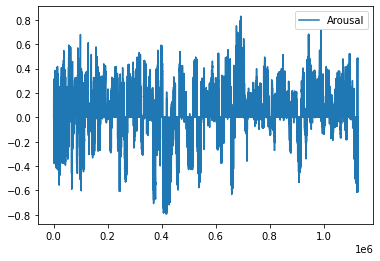

In [38]:
print(len(pred_test_list), inv_y.shape)
submission.loc[1:, ['Arousal', 'Prediction']].plot()
submission.to_csv('submission.csv', index=False)

In [33]:
correlation = submission.corr(method='pearson')
print(correlation)

         Arousal
Arousal      1.0


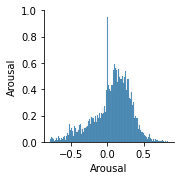

In [34]:
d0 = submission[['Arousal', 'Prediction']]
sns.pairplot(d0, kind="scatter")
plt.show()